## fill in blank generation(resume + jd)

In [83]:
import json

with open('resume_features.json', 'r') as file:
    js = json.load(file)  # Use json.load() instead of json.loads()
    
def generate_resume_summary(data):
    summary = []
    
    # Check and add school if available
    if data.get('school'):
        summary.append(f"My school is {data['school']}.")
    
    # Check and add GPA if available
    if data.get('gpa') is not None:
        summary.append(f"My GPA is {data['gpa']}.")
    
    # Check and add research area if available
    if data.get('research_area') is not None:
        summary.append(f"My research area is {data['research_area']}.")
    
    # Check and add skills if available
    if data.get('skills'):
        skills = ', '.join(data['skills'])
        summary.append(f"My skills are {skills}.")
    
    return ' '.join(summary)

import csv
    
with open('fill_in_blank_resume.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(['Summary'])
    
    # Process each dictionary in data_list and write the summary to the CSV
    for i in range(len(js)):
        start_index = js[i].find('{')
        end_index = js[i].rfind('}')
        try: 
            summary = generate_resume_summary(json.loads(js[i][start_index:end_index + 1].replace('\n', '')))
        except:
            print(i)
            print(js[i])
            summary = js[i]
        writer.writerow([summary])


656
Please provide the resume text. I need the content of the resume to extract the requested information and return it in the JSON format.



In [ ]:
import pandas as pd
s = pd.read_csv("training_data.csv")['model_response'].tolist()

def generate_jd_summary(job_data):
    summary = []

    # Check and add Core Responsibilities if available
    if job_data.get('Core Responsibilities'):
        summary.append(f"Core responsibilities include {job_data['Core Responsibilities']}.")

    # Check and add Required Skills if available
    if job_data.get('Required Skills'):
        summary.append(f"Required skills are {job_data['Required Skills']}.")

    # Check and add Educational Requirements if available and not "N/A"
    if job_data.get('Educational Requirements') and job_data['Educational Requirements'] != "N/A":
        summary.append(f"The educational requirements include {job_data['Educational Requirements']}.")

    # Check and add Experience Level if available and not "N/A"
    if job_data.get('Experience Level') and job_data['Experience Level'] != "N/A":
        summary.append(f"Preferred experience level is {job_data['Experience Level']}.")

    # Check and add Preferred Qualifications if available and not "N/A"
    if job_data.get('Preferred Qualifications') and job_data['Preferred Qualifications'] != "N/A":
        summary.append(f"Preferred qualifications include {job_data['Preferred Qualifications']}.")

    if job_data.get('Compensation and Benefits') and job_data['Compensation and Benefits'] != "N/A":
        summary.append(f"Compensation and Benefits include {job_data['Compensation and Benefits']}.")
        
    return ' '.join(summary)

with open('fill_in_blank_jd.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(['Summary'])
    
    # Process each dictionary in data_list and write the summary to the CSV
    for i in range(len(s)):
        start_index = js[i].find('{')
        end_index = js[i].rfind('}')
        try: 
            summary = generate_jd_summary(json.loads(s[i].replace('\n', '')))
        except:
            print(i)
            print(js[i])
            summary = js[i]
        writer.writerow([summary])


## generate label

In [86]:
import pandas as pd
jd = pd.read_csv('fill_in_blank_jd.csv')
resume = pd.read_csv('fill_in_blank_resume.csv')

In [97]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # Extract [CLS] token representation
    return cls_embedding

def sliding_window_split(text, window_size=512, stride=256):
    # Sliding window approach to split the text into overlapping windows
    tokens = tokenizer.tokenize(text)
    windows = []
    for i in range(0, len(tokens), stride):
        window = tokens[i:i + window_size]
        if len(window) > 0:
            windows.append(tokenizer.convert_tokens_to_string(window))
    return windows

def process_long_text(long_text):
    # If the text is short enough (<= 512 tokens), directly process it
    if len(tokenizer.tokenize(long_text)) <= 512:
        return get_bert_embedding(long_text)
    
    # Otherwise, apply sliding window to split the text
    windows = sliding_window_split(long_text)
    
    embeddings = []
    for window in windows:
        embedding = get_bert_embedding(window)
        embeddings.append(embedding)
    
    # Aggregate window embeddings (e.g., by averaging them)
    if embeddings:
        aggregated_embedding = torch.mean(torch.stack(embeddings), dim=0)
        return aggregated_embedding
    else:
        return None
    
def cosine_similarity(embedding1, embedding2):
    # Compute the cosine similarity between two embeddings
    sim = F.cosine_similarity(embedding1, embedding2)
    return sim.item()

In [102]:
pairs = pd.read_csv('job_resume_top10_with_full_details.csv')[['job_index', 'resume_index']]
# 初始化列表用于存储结果
results = []

for i in range(len(pairs)):
    print(i)
    job_index = pairs.job_index[i]
    resume_index = pairs.resume_index[i]
    embedding1 = process_long_text(jd.loc[job_index].Summary)
    embedding2 = process_long_text(resume.loc[resume_index].Summary)

    # Calculate the cosine similarity between the two embeddings
    similarity = cosine_similarity(embedding1, embedding2)
    
    results.append([job_index, resume_index, similarity])
# 转换为 DataFrame 并保存到 CSV
df_results = pd.DataFrame(results, columns=['job_index', 'resume_index', 'similarity'])
df_results.to_csv('job_resume_similarity.csv', index=False)
 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [105]:
result = pd.read_csv('job_resume_similarity.csv')

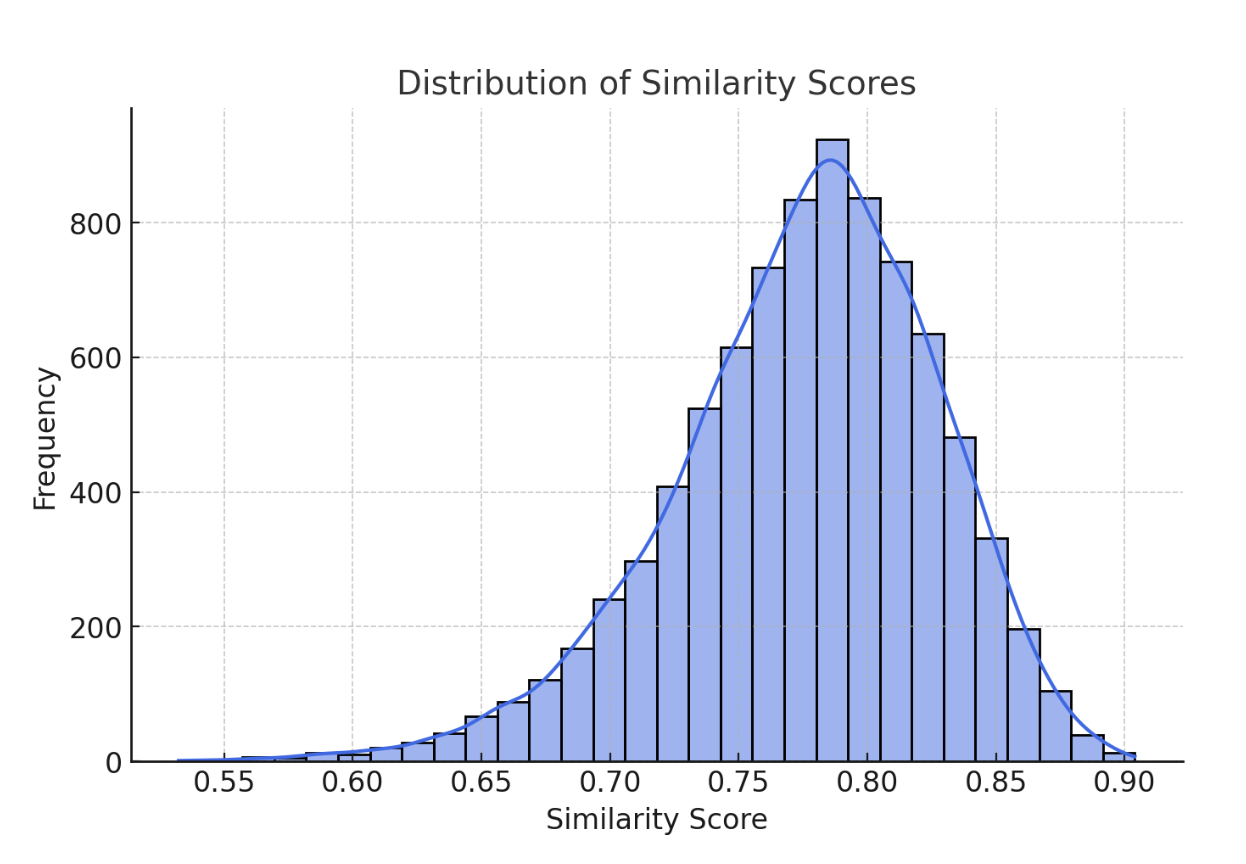

	•	均值 (mean)： 0.7755
	•	标准差 (std)： 0.0515
	•	最小值 (min)： 0.5324
	•	最大值 (max)： 0.9040
	•	中位数 (median)： 0.7806
	•	四分位数：
	•	25%: 0.7446
	•	50% (中位数): 0.7806
	•	75%: 0.8116

In [109]:
for threshold in range(70, 86):
    result[f'label_{threshold/100}'] = result['similarity'] >= threshold/100
result.to_csv('job_resume_similarity_labels.csv', index=False)